<a href="https://colab.research.google.com/github/Hernanros/Y_Data_DL/blob/HW%234-answers/%5BHW%234%20super%20resulutaion%20FCN%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initializations

In [3]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=977a088b645b1cb9f35541b44368b16e8230e0dce72d273c65ab5575d93b0987
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#augmentation library
import albumentations as A

import urllib
import tarfile
import os
import tempfile
import wget

In [5]:
! git clone -b HW#4-answers https://github.com/Hernanros/Y_Data_DL DL-Branch


Cloning into 'DL-Branch'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 292 (delta 21), reused 15 (delta 6), pack-reused 250
Receiving objects: 100% (292/292), 568.12 MiB | 34.63 MiB/s, done.
Resolving deltas: 100% (125/125), done.


In [6]:
%cd /content/DL-Branch/[HW#4]Super_resulutation_FCN

/content/DL-Branch/[HW#4]Super_resulutation_FCN


In [0]:
url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
file_tmp = wget.download(url)

tar = tarfile.open(file_tmp)
tar.extractall()

In [0]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# ! tar -xvf VOCtrainval_06-Nov-2007.tar

## Getting Data

In [0]:
# initialize a list of file paths for photos
photos = glob.glob('./VOCdevkit/VOC2007/JPEGImages/*.jpg')

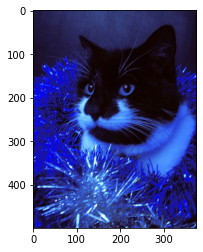

In [9]:
plt.imshow(cv2.imread(photos[0]));

In [0]:
# samples random 100 images to play with from raw data
np.random.set_state = 42
mini_dataset_ind = np.random.choice(len(photos),100,False)
sample = []
[sample.append(cv2.imread(photos[ind])) for ind in mini_dataset_ind]
sample = np.array(sample)

In [0]:
# Resized the original image to 288 x 288 - and from that imaged resized to 144 and 72 (same aspect ratio)

y_large = [cv2.resize(sample[ind] , (288,288)) for ind in range(len(sample))]
y_mid = [cv2.resize(y_large[ind] , (144,144)) for ind in range(len(sample))]
x_train = [cv2.resize(y_large[ind] , (72,72)) for ind in range(len(sample))]

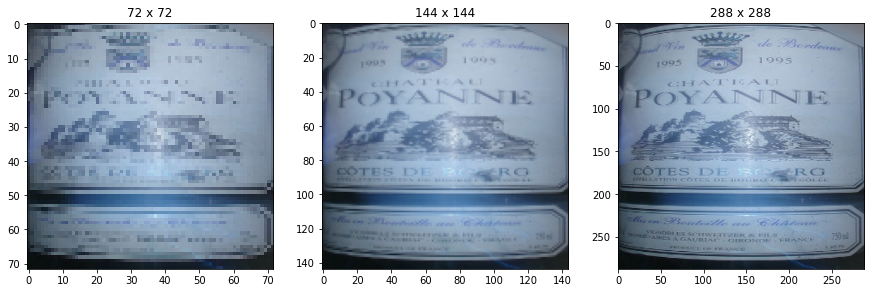

In [12]:
i = np.random.randint(100)

f = plt.figure(figsize=(15,5))

ax_0 = f.add_subplot(1,3,1)
ax_0.imshow(x_train[i])
ax_0.set_title("72 x 72")

ax_1 = f.add_subplot(1,3,2)
ax_1.imshow(y_mid[i])
ax_1.set_title("144 x 144")

ax_2 = f.add_subplot(1,3,3)
ax_2.imshow(y_large[i])
ax_2.set_title("288 x 288");

In [0]:
#divide the data into train and test

inds = np.random.choice(100,100,False)

X_train, y_mid_train, y_large_train = np.array(x_train)[inds[:80]], np.array(y_mid)[inds[:80]], np.array(y_large)[inds[:80]]

X_test, y_mid_test, y_large_test = np.array(x_train)[inds[80:]], np.array(y_mid)[inds[80:]], np.array(y_large)[inds[80:]]

In [0]:
 class DS_mid(Dataset):
    def __init__(self,df,labels, transforms=None):
        super().__init__()
        self.df=df
        self.labels=labels
        self.transforms=transforms
 
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img= self.df[idx]
        label = self.labels[idx]        
        if not self.transforms is None:
            transformed_img = self.transforms(image=img)
            img = transformed_img['image']
        return img,label

In [0]:
train_set = DS_mid(X_train,y_mid_train)
test_set= DS_mid(X_test,y_mid_test)

train_loader=DataLoader(dataset= train_set, batch_size = 4, shuffle = True, num_workers = 2)
test_loader=DataLoader(dataset= test_set, batch_size = 4, shuffle = True, num_workers = 2)

### loss evaluation
PSNR loss function that evaluates the mean square loss per pixle (l2 loss).<br>
$$PSNR_{l2} = \frac{1}{mn}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1}[I(i,j)-K(i,j)]^2$$
where I is the ground truth and K is the recostructed image<br>

other variations of PSNR loss functions consider using l1 loss (Mean Absolute error) as the loss function<br>
$$ PSNR_{l1} = \frac{1}{mn}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1}|I(i,j)-K(i,j)|$$

In [0]:
import pytorch_ssim as ssi
import models.model1 as model1
l2 = nn.MSELoss()
l1= nn.L1Loss()

model = model1.firstmodel()
criterion = ssi.ssim
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

In [0]:
def train_fold_mid(tr_loader,model,criterion,optimizer, num_epochs):
    model.to(device)
    
    training_log =[]

    
    for epoch in range(num_epochs):
      print("started training epoch no. {}".format(epoch+1))
      tr_loss = 0
      for step,batch in enumerate(tr_loader):
            imgs, labels = batch
            imgs=imgs.to(device,dtype=torch.float32)
            labels = labels.to(device,dtype=torch.float32)
            outputs = model(imgs)

            loss = 1-criterion(outputs, labels, window_size=12)
            loss.backward()
            tr_loss+=loss.item()
            optimizer.step()
            optimizer.zero_grad()

      training_log.append({
                'epoch':epoch,
                'train_loss':tr_loss / len(tr_loader),
                })
      
    return training_log




def test_evaluation_mid(tst_loader,model,losses):  
    model.eval()

    loss_ssim = 0
    loss_mse = 0
    loss_mae = 0
    N=0

    for step,batch in enumerate(tst_loader):
        imgs, labels = batch
        
        
        imgs = imgs.to(device,dtype=torch.float32)
        labels = labels.to(device,dtype=torch.float32)
        outputs = model(imgs)

        loss_ssim += 1-losses[0](outputs,labels, window_size=12).item()
        loss_mse += losses[1](outputs,labels).item()
        loss_mae += losses[2](outputs,labels).item()
        N += len(batch)
    f,ax = plt.subplots(batch[0].shape[0], 3 ,figsize = (5*batch[0].shape[0],15) )
    
    imgs , labels= imgs.cpu().detach().numpy().astype(int), labels.cpu().detach().numpy().astype(int)
    outputs_hats = np.abs(outputs.cpu().detach().numpy().astype(int))

    for i in range(batch[0].shape[0]):
      orig_x , orig_y= imgs[i], labels[i]
      outputs = outputs_hats[i]
      val=0
      ax[i,val].imshow(orig_x)
      ax[i,val].set_title('original 72*72 image')

      val+=1
      ax[i,val].imshow(outputs)
      ax[i,val].set_title('model output')
      
      val+=1
      ax[i,val].imshow(orig_y)
      ax[i,val].set_title('target image')
      
    print ("test set results:\n SSIM:{}\tL1 loss(MSE):{}\tL2 loss(MAE):{}".format(loss_ssim/N, loss_mse/N, loss_mae/N))

In [64]:
train_fold_mid(train_loader,model,criterion,optimizer,num_epochs= 50)

started training epoch no. 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


started training epoch no. 2
started training epoch no. 3
started training epoch no. 4
started training epoch no. 5
started training epoch no. 6
started training epoch no. 7
started training epoch no. 8
started training epoch no. 9
started training epoch no. 10
started training epoch no. 11
started training epoch no. 12
started training epoch no. 13
started training epoch no. 14
started training epoch no. 15
started training epoch no. 16
started training epoch no. 17
started training epoch no. 18
started training epoch no. 19
started training epoch no. 20
started training epoch no. 21
started training epoch no. 22
started training epoch no. 23
started training epoch no. 24
started training epoch no. 25
started training epoch no. 26
started training epoch no. 27
started training epoch no. 28
started training epoch no. 29
started training epoch no. 30
started training epoch no. 31
started training epoch no. 32
started training epoch no. 33
started training epoch no. 34
started training e

[{'epoch': 0, 'train_loss': 0.9709432750940323},
 {'epoch': 1, 'train_loss': 0.9269089251756668},
 {'epoch': 2, 'train_loss': 0.39185594618320463},
 {'epoch': 3, 'train_loss': 0.18819287717342376},
 {'epoch': 4, 'train_loss': 0.17383477091789246},
 {'epoch': 5, 'train_loss': 0.16786420941352845},
 {'epoch': 6, 'train_loss': 0.16459035575389863},
 {'epoch': 7, 'train_loss': 0.161954465508461},
 {'epoch': 8, 'train_loss': 0.15835120379924775},
 {'epoch': 9, 'train_loss': 0.15490275621414185},
 {'epoch': 10, 'train_loss': 0.1511167913675308},
 {'epoch': 11, 'train_loss': 0.14695699512958527},
 {'epoch': 12, 'train_loss': 0.142765074968338},
 {'epoch': 13, 'train_loss': 0.1390938103199005},
 {'epoch': 14, 'train_loss': 0.13530759513378143},
 {'epoch': 15, 'train_loss': 0.13109686076641083},
 {'epoch': 16, 'train_loss': 0.12714460194110871},
 {'epoch': 17, 'train_loss': 0.1222662091255188},
 {'epoch': 18, 'train_loss': 0.11883780062198639},
 {'epoch': 19, 'train_loss': 0.11615042984485627},

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test set results:
 SSIM:0.04959080219268799	L1 loss(MSE):31513.192578125	L2 loss(MAE):107.70281066894532


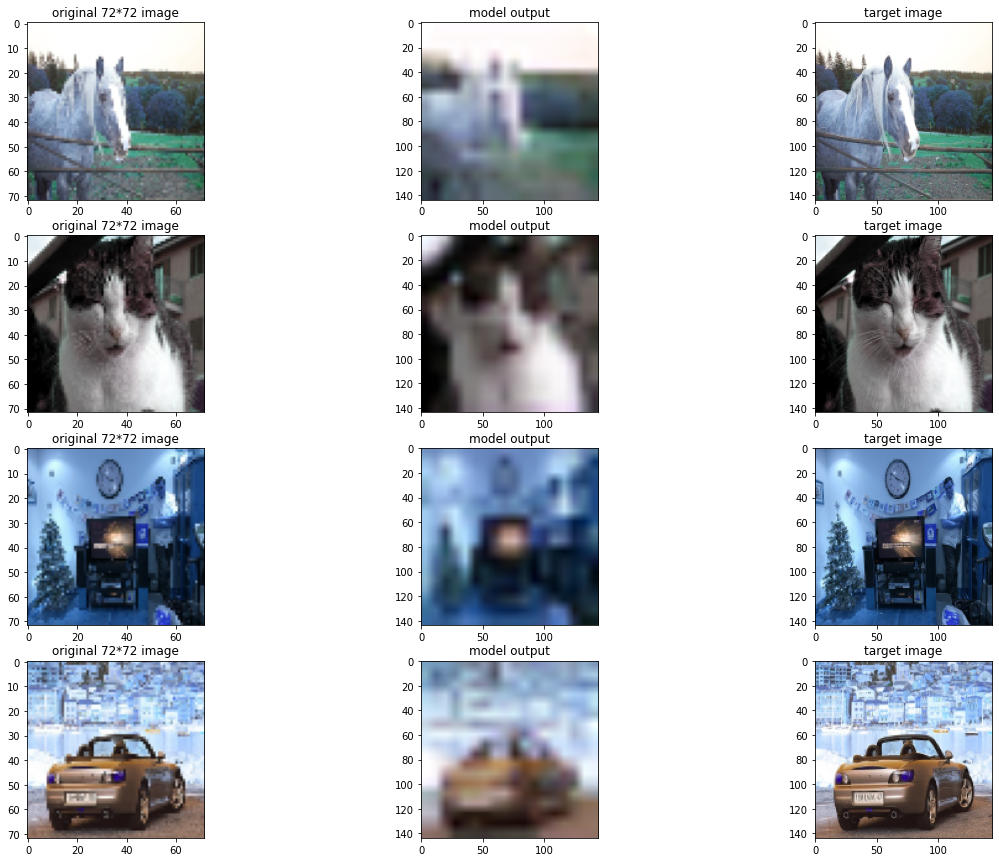

In [65]:
test_evaluation_mid(test_loader,model,[criterion,l2,l1])

### model 2
in this model we want to use the basic model and concatenate to it the original 144*144 values

In [0]:
 class DS_both(Dataset):
    def __init__(self,df,labels_mid,labels_large, transforms=None):
        super().__init__()
        self.df=df
        self.labels_mid=labels_mid
        self.labels_large=labels_large
        self.transforms=transforms
 
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img= self.df[idx]
        labels_mid = self.labels_mid[idx]   
        labels_large = self.labels_large[idx]        
        if not self.transforms is None:
            transformed_img = self.transforms(image=img)
            img = transformed_img['image']
        return img,labels_mid,labels_large
        

In [0]:
train_set = DS_both(X_train,y_mid_train,y_large_train)
test_set= DS_both(X_test,y_mid_test, y_large_test)

train_loader=DataLoader(dataset= train_set, batch_size = 4, shuffle = True, num_workers = 2)
test_loader=DataLoader(dataset= test_set, batch_size = 4, shuffle = True, num_workers = 2)

In [0]:
import models.model2 as model2

model= model2.second_model()
l2 = nn.MSELoss()
l1= nn.L1Loss()
criterion = ssi.ssim
optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.has_cuda:
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu:0')

In [0]:
def train_fold_both(tr_loader,model,criterion,optimizer, num_epochs):
    
    model.to(device)
    
    training_log =[]
    
    for epoch in range(num_epochs):
      print("started training epoch no. {}".format(epoch+1))
      tr_loss = 0
      for step,batch in enumerate(tr_loader):
            imgs, labels_mid, labels_large = batch
            imgs=imgs.to(device,dtype=torch.float32)
            labels_mid,labels_large = labels_mid.to(device,dtype=torch.float32), labels_large.to(device,dtype=torch.float32)
            outputs_1, outputs_2 = model(imgs)
            loss = (1-criterion(outputs_1, labels_mid, window_size=12)) + (1-criterion(outputs_2, labels_large, window_size=12))
            loss.backward()
            tr_loss+=loss.item()
            optimizer.step()
            optimizer.zero_grad()

      training_log.append({
                'epoch':epoch,
                'train_loss':tr_loss / len(tr_loader),
                })
      
    return training_log




def test_evaluation_both(tst_loader,model,losses):  
    model.eval()

    loss_ssim = 0
    loss_mse = 0
    loss_mae = 0
    N=0

    for step,batch in enumerate(tst_loader):
        imgs, labels_mid, labels_large = batch
        
        
        imgs = imgs.to(device,dtype=torch.float32)
        labels_mid, labels_large = labels_mid.to(device,dtype=torch.float32), labels_large.to(device,dtype=torch.float32)
        outputs = model(imgs)

        loss_ssim += (1-losses[0](outputs[0],labels_mid, window_size=12).item()) + (1-losses[0](outputs[1],labels_large, window_size=12).item())
        loss_mse += losses[1](outputs[0],labels_mid).item() + (losses[1](outputs[1],labels_large).item())
        loss_mae += losses[2](outputs[0],labels_mid).item() + losses[2](outputs[1],labels_large).item()
        N += len(batch)
    f,ax = plt.subplots(batch[0].shape[0], 5 ,figsize = (5*batch[0].shape[0],25) )
    
    imgs , labels_mid , labels_large = imgs.cpu().detach().numpy().astype(int), labels_mid.cpu().detach().numpy().astype(int), labels_large.cpu().detach().numpy().astype(int)
    outputs_small,outputs_large = np.abs(outputs[0].cpu().detach().numpy().astype(int)),np.abs(outputs[1].cpu().detach().numpy().astype(int))

    for i in range(batch[0].shape[0]):
      orig_x , orig_mid, orig_large= imgs[i], labels_mid[i], labels_large[i]
      output1 = outputs_small[i]
      output2 = outputs_large[i]
      val=0
      ax[i,val].imshow(orig_x)
      ax[i,val].set_title('original 72*72 image')

      val+=1
      ax[i,val].imshow(output1)
      ax[i,val].set_title('model output small')
      
      val+=1
      ax[i,val].imshow(orig_mid)
      ax[i,val].set_title('target image(mid)')

      val+=1
      ax[i,val].imshow(output2)
      ax[i,val].set_title('model output large')


      val+=1
      ax[i,val].imshow(orig_large)
      ax[i,val].set_title('target image(large)')
      
    print ("test set results:\n SSIM:{}\tL1 loss(MSE):{}\tL2 loss(MAE):{}".format(loss_ssim/N, loss_mse/N, loss_mae/N))
        

In [43]:
train_fold_both(train_loader,model,criterion,optimizer,num_epochs= 10)

started training epoch no. 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


started training epoch no. 2
started training epoch no. 3
started training epoch no. 4
started training epoch no. 5
started training epoch no. 6
started training epoch no. 7
started training epoch no. 8
started training epoch no. 9
started training epoch no. 10


[{'epoch': 0, 'train_loss': 1.0757023841142654},
 {'epoch': 1, 'train_loss': 1.0303640067577362},
 {'epoch': 2, 'train_loss': 0.9829248398542404},
 {'epoch': 3, 'train_loss': 0.9046105533838272},
 {'epoch': 4, 'train_loss': 0.8553297251462937},
 {'epoch': 5, 'train_loss': 0.7948196262121201},
 {'epoch': 6, 'train_loss': 0.7542001098394394},
 {'epoch': 7, 'train_loss': 0.700780501961708},
 {'epoch': 8, 'train_loss': 0.6888128519058228},
 {'epoch': 9, 'train_loss': 0.6436383426189423}]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


test set results:
 SSIM:0.31150420308113097	L1 loss(MSE):20280.232421875	L2 loss(MAE):105.76335245768229


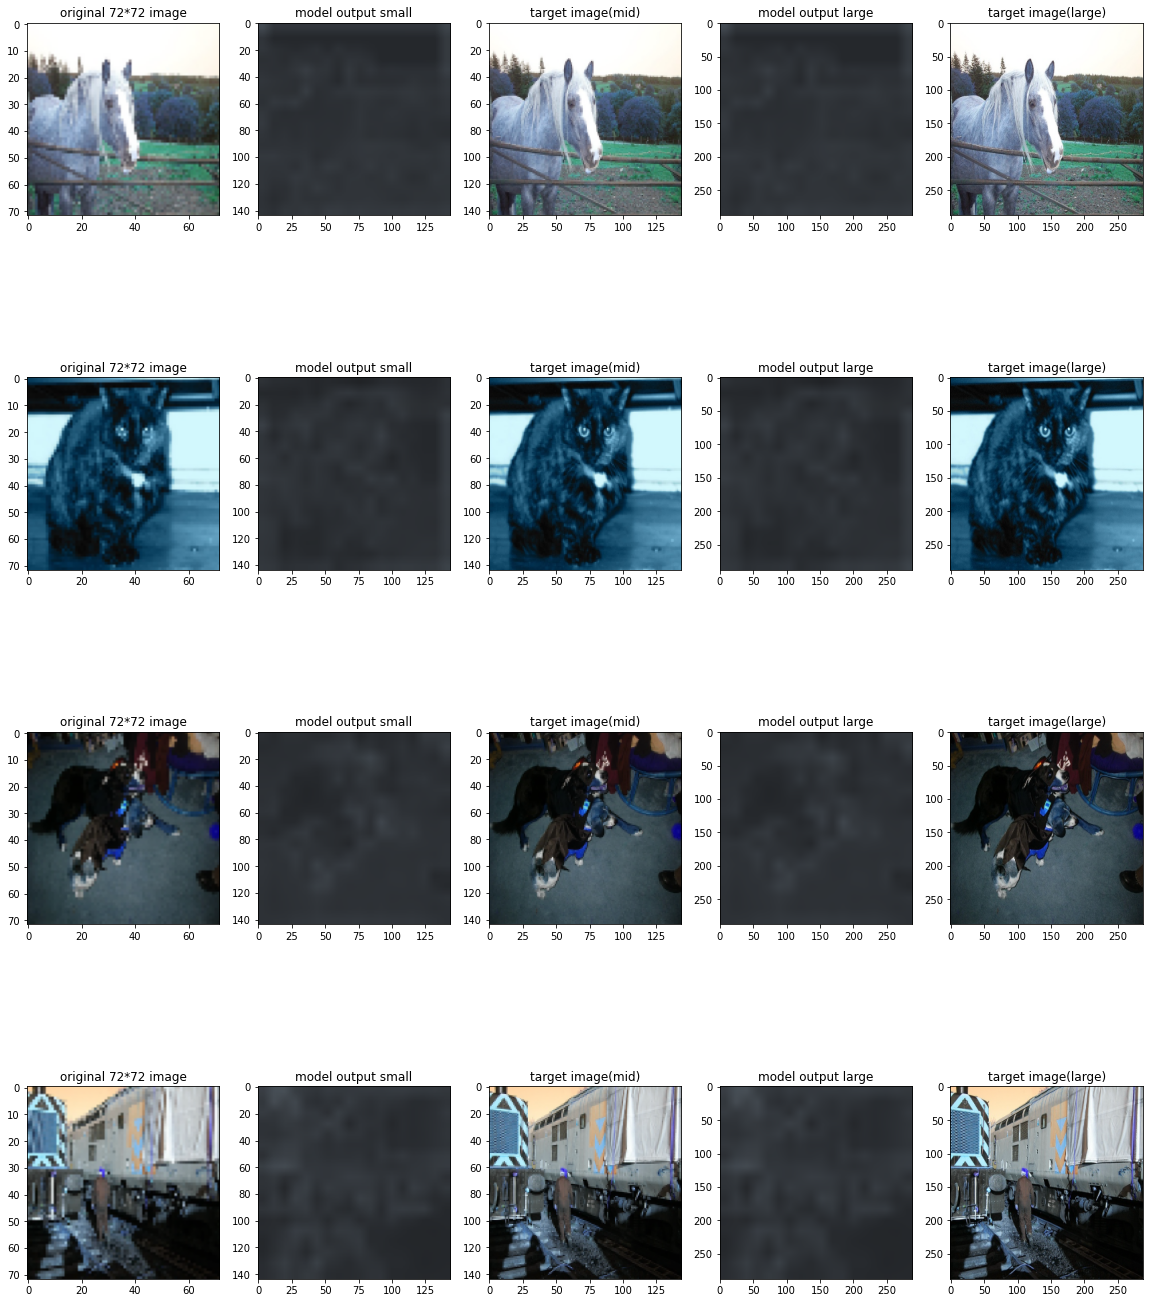

In [44]:
test_evaluation_both(test_loader,model,[criterion,l2,l1])